https://stackoverflow.com/questions/57713358/how-to-rotate-skewed-fingerprint-image-to-vertical-upright-position

https://stackoverflow.com/questions/49907382/how-to-remove-whitespace-from-an-image-in-opencv

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode

In [2]:
def show_map(img):
    fig, ax = plt.subplots(figsize = (10,5))
    ax.imshow(img)
    plt.show()

In [3]:
def rotate_crop_map(map_img):
    gray = cv.cvtColor(map_img, cv.COLOR_RGB2GRAY)
    gray = 255 - gray
    thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)[1]

    # Compute rotated bounding box
    coords = np.column_stack(np.where(thresh > 0))
    center_rect, dims, angle = cv.minAreaRect(coords)

    if angle < -45:
        angle = -angle
    else:
        angle = 90-angle
    print(angle)

    # Rotate image to deskew
    (h, w) = map_img.shape[:2]
    center = (w // 2, h // 2)
    M = cv.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv.warpAffine(map_img, M, (w, h), flags=cv.INTER_CUBIC, borderMode=cv.BORDER_REPLICATE)

    gray = cv.cvtColor(rotated, cv.COLOR_BGR2GRAY)
    gray = 255*(gray < 128).astype(np.uint8) # To invert the text to white
    coords = cv.findNonZero(gray) # Find all non-zero points (text)
    x, y, w, h = cv.boundingRect(coords) # Find minimum spanning bounding box
    rect = rotated[y:y+h, x:x+w] 
    rect = cv.cvtColor(rect, cv.COLOR_BGR2RGB)
    
    return rect

0.8036956787109375


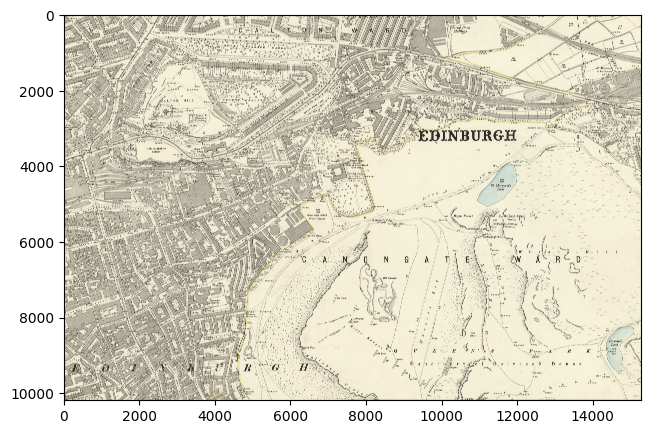

In [4]:
map_1 = cv.imread("../../pics/report/map_1.tif")
fix_map_1 = rotate_crop_map(map_1)
show_map(fix_map_1)

map_1 = cv.imread("data/originals/82877409.27.tif")
fix_map_1 = rotate_crop_map(map_1)
show_map(fix_map_1)

map_2 = cv.imread("data/originals/82877412.27.tif")
fix_map_2 = rotate_crop_map(map_2)
show_map(fix_map_2)

map_3 = cv.imread("data/originals/82877415.27.tif")
fix_map_3 = rotate_crop_map(map_3)
show_map(fix_map_3)

map_4 = cv.imread("data/originals/82877418.27.tif")
fix_map_4 = rotate_crop_map(map_4)
show_map(fix_map_4)

In [5]:
import PIL
from PIL import Image

PIL.Image.MAX_IMAGE_PIXELS = 933120000

pil_map_1 = Image.fromarray(fix_map_1)
pil_map_1.save("data/map_1.tif")

pil_map_2 = Image.fromarray(fix_map_2)
pil_map_2.save("data/map_2.tif")

pil_map_3 = Image.fromarray(fix_map_3)
pil_map_3.save("data/map_3.tif")

pil_map_4 = Image.fromarray(fix_map_4)
pil_map_4.save("data/map_4.tif")

In [5]:
fix_map_1 = np.array(Image.open("data/map_1.tif"))
fix_map_2 = np.array(Image.open("data/map_2.tif"))
fix_map_3 = np.array(Image.open("data/map_3.tif"))
fix_map_4 = np.array(Image.open("data/map_4.tif"))

In [6]:
from skimage.measure import block_reduce

In [7]:
red_map_1_max = block_reduce(fix_map_1, block_size = (2,2,1), func = np.max)
#show_map(red_map_1_max)

In [8]:
red_map_1_min = block_reduce(fix_map_1, block_size = (2,2,1), func = np.min)
#show_map(red_map_1_min)

In [9]:
red_map_1_min_3 = block_reduce(fix_map_1, block_size = (3,3,1), func = np.min)
#show_map(red_map_1_min_3)

In [12]:
red_map_1_min_4 = block_reduce(fix_map_1, block_size = (4,4,1), func = np.min)
#show_map(red_map_1_min_4)

In [13]:
def med_reduce(x, axis):
    return np.median(x,axis).astype(np.int32)

In [14]:
def mean_reduce(x, axis):
    return np.mean(x,axis).astype(np.int32)

In [15]:
red_map_1_med = block_reduce(fix_map_1, block_size = (2,2,1), func = med_reduce)
#show_map(red_map_1_med)

In [16]:
red_map_1_med_3 = block_reduce(fix_map_1, block_size = (3,3,1), func = med_reduce)
#show_map(red_map_1_med_3)

In [17]:
red_map_1_med_4 = block_reduce(fix_map_1, block_size = (4,4,1), func = med_reduce)
#show_map(red_map_1_med_4)

In [18]:
mean_resize = block_reduce(fix_map_1, block_size = (2,2,1), func = mean_reduce)
#show_map(mean_resize)

mean_resize_3 = block_reduce(fix_map_1, block_size = (3,3,1), func = mean_reduce)
#show_map(mean_resize_3)

mean_resize_4 = block_reduce(fix_map_1, block_size = (4,4,1), func = mean_reduce)
#show_map(mean_resize_4)

In [19]:
def downsample_map(map_, factor, interpolation = InterpolationMode.BILINEAR):
    size = map_.shape
    
    new_size = (size[0]//factor, size[1]//factor)
    
    tensor_map = np.moveaxis(map_, -1, 0)
    tensor_map = torch.Tensor(tensor_map)
    
    resized_map = T.Resize(new_size, interpolation=interpolation)(tensor_map)
    
    resized_map = resized_map.numpy()
    resized_map = np.moveaxis(resized_map, 0, -1)
    
    return resized_map.astype(int)

In [20]:
bilinear_resize = downsample_map(fix_map_1,2, interpolation = InterpolationMode.BILINEAR)
#show_map(bilinear_resize)

bilinear_resize_3 = downsample_map(fix_map_1,3, interpolation = InterpolationMode.BILINEAR)
#show_map(bilinear_resize_3)

bilinear_resize_4 = downsample_map(fix_map_1,4, interpolation = InterpolationMode.BILINEAR)
#show_map(bilinear_resize_4)

In [21]:
bicubic_resize = downsample_map(fix_map_1,2, interpolation = InterpolationMode.BICUBIC)
#show_map(bicubic_resize)

bicubic_resize_3 = downsample_map(fix_map_1,3, interpolation = InterpolationMode.BICUBIC)
#show_map(bicubic_resize_3)

bicubic_resize_4 = downsample_map(fix_map_1,4, interpolation = InterpolationMode.BICUBIC)
#show_map(bicubic_resize_4)

In [22]:
nearest_resize = downsample_map(fix_map_1,2, interpolation = InterpolationMode.NEAREST)
#show_map(nearest_resize)

nearest_resize_3 = downsample_map(fix_map_1,3, interpolation = InterpolationMode.NEAREST)
#show_map(nearest_resize_3)

nearest_resize_4 = downsample_map(fix_map_1,4, interpolation = InterpolationMode.NEAREST)
#show_map(nearest_resize_4)

In [60]:
map_dict = {"original": (fix_map_1,1),
            r"$2 \times 2$ Bilinear": (bilinear_resize, 2),
            r"$3 \times 3$ Bilinear": (bilinear_resize_3, 3),
            r"$4 \times 4$ Bilinear": (bilinear_resize_4, 4),
            r"$2 \times 2$ Bicubic": (bicubic_resize, 2),
            r"$3 \times 3$ Bicubic": (bicubic_resize_3, 3),
            r"$4 \times 4$ Bicubic": (bicubic_resize_4, 4),
            r"$2 \times 2$ Nearest": (nearest_resize, 2),
            r"$3 \times 3$ Nearest": (nearest_resize_3, 3),
            r"$4 \times 4$ Nearest": (nearest_resize_4, 4)}

In [41]:
map_dict_2 = {"original": (fix_map_1,1),
            r"$2 \times 2$ Minimum": (red_map_1_min,2),
            r"$3 \times 3$ Minimum": (red_map_1_min_3,3),
            r"$4 \times 4$ Minimum": (red_map_1_min_4,4),
            r"$2 \times 2$ Median": (red_map_1_med,2),
            r"$3 \times 3$ Median": (red_map_1_med_3,3),
            r"$4 \times 4$ Median": (red_map_1_med_4,4),
            r"$2 \times 2$ Mean": (mean_resize,2),
            r"$3 \times 3$ Mean": (mean_resize_3,3),
            r"$4 \times 4$ Mean": (mean_resize_4,4)}

In [42]:
map_dict_3 = {"original": (fix_map_1,1),
            r"$2 \times 2$ Bilinear": (bilinear_resize, 2),
            r"$3 \times 3$ Bilinear": (bilinear_resize_3, 3),
            r"$4 \times 4$ Bilinear": (bilinear_resize_4, 4),
            r"$2 \times 2$ Bicubic": (bicubic_resize, 2),
            r"$3 \times 3$ Bicubic": (bicubic_resize_3, 3),
            r"$4 \times 4$ Bicubic": (bicubic_resize_4, 4),
            r"$2 \times 2$ Mean": (mean_resize,2),
            r"$3 \times 3$ Mean": (mean_resize_3,3),
            r"$4 \times 4$ Mean": (mean_resize_4,4)}

In [61]:
def compare_map_transforms(map_dict, patch_size, origin, n_transforms, save = None):
    rows = (len(map_dict)-1)//n_transforms
    cols = n_transforms+1
    fig, ax = plt.subplots(rows,cols,figsize = (cols*5,rows*5))
    fig.tight_layout()

    for i, (name, (map_, scale)) in enumerate(map_dict.items()):
        x = origin[0]//scale
        y = origin[1]//scale
        patch = map_[x:x + patch_size, y:y + patch_size]
        if i == 0:
            for j in range(rows):
                ax[j,0].imshow(patch)
                ax[j,0].set_title(name, fontsize = 35)
                ax[j,0].axis("off")
        else:
            k = i-1
            ax[k % rows, 1 + k//rows].imshow(patch)
            ax[k % rows, 1 + k//rows].set_title(name, fontsize = 35)
            ax[k % rows, 1 + k//rows].axis("off")
            
    if save is not None:
        plt.savefig(save, bbox_inches="tight")
        
    plt.show()

In [62]:
#compare_map_transforms(map_dict_3, 64, (0,0), n_transforms=3, save = None)

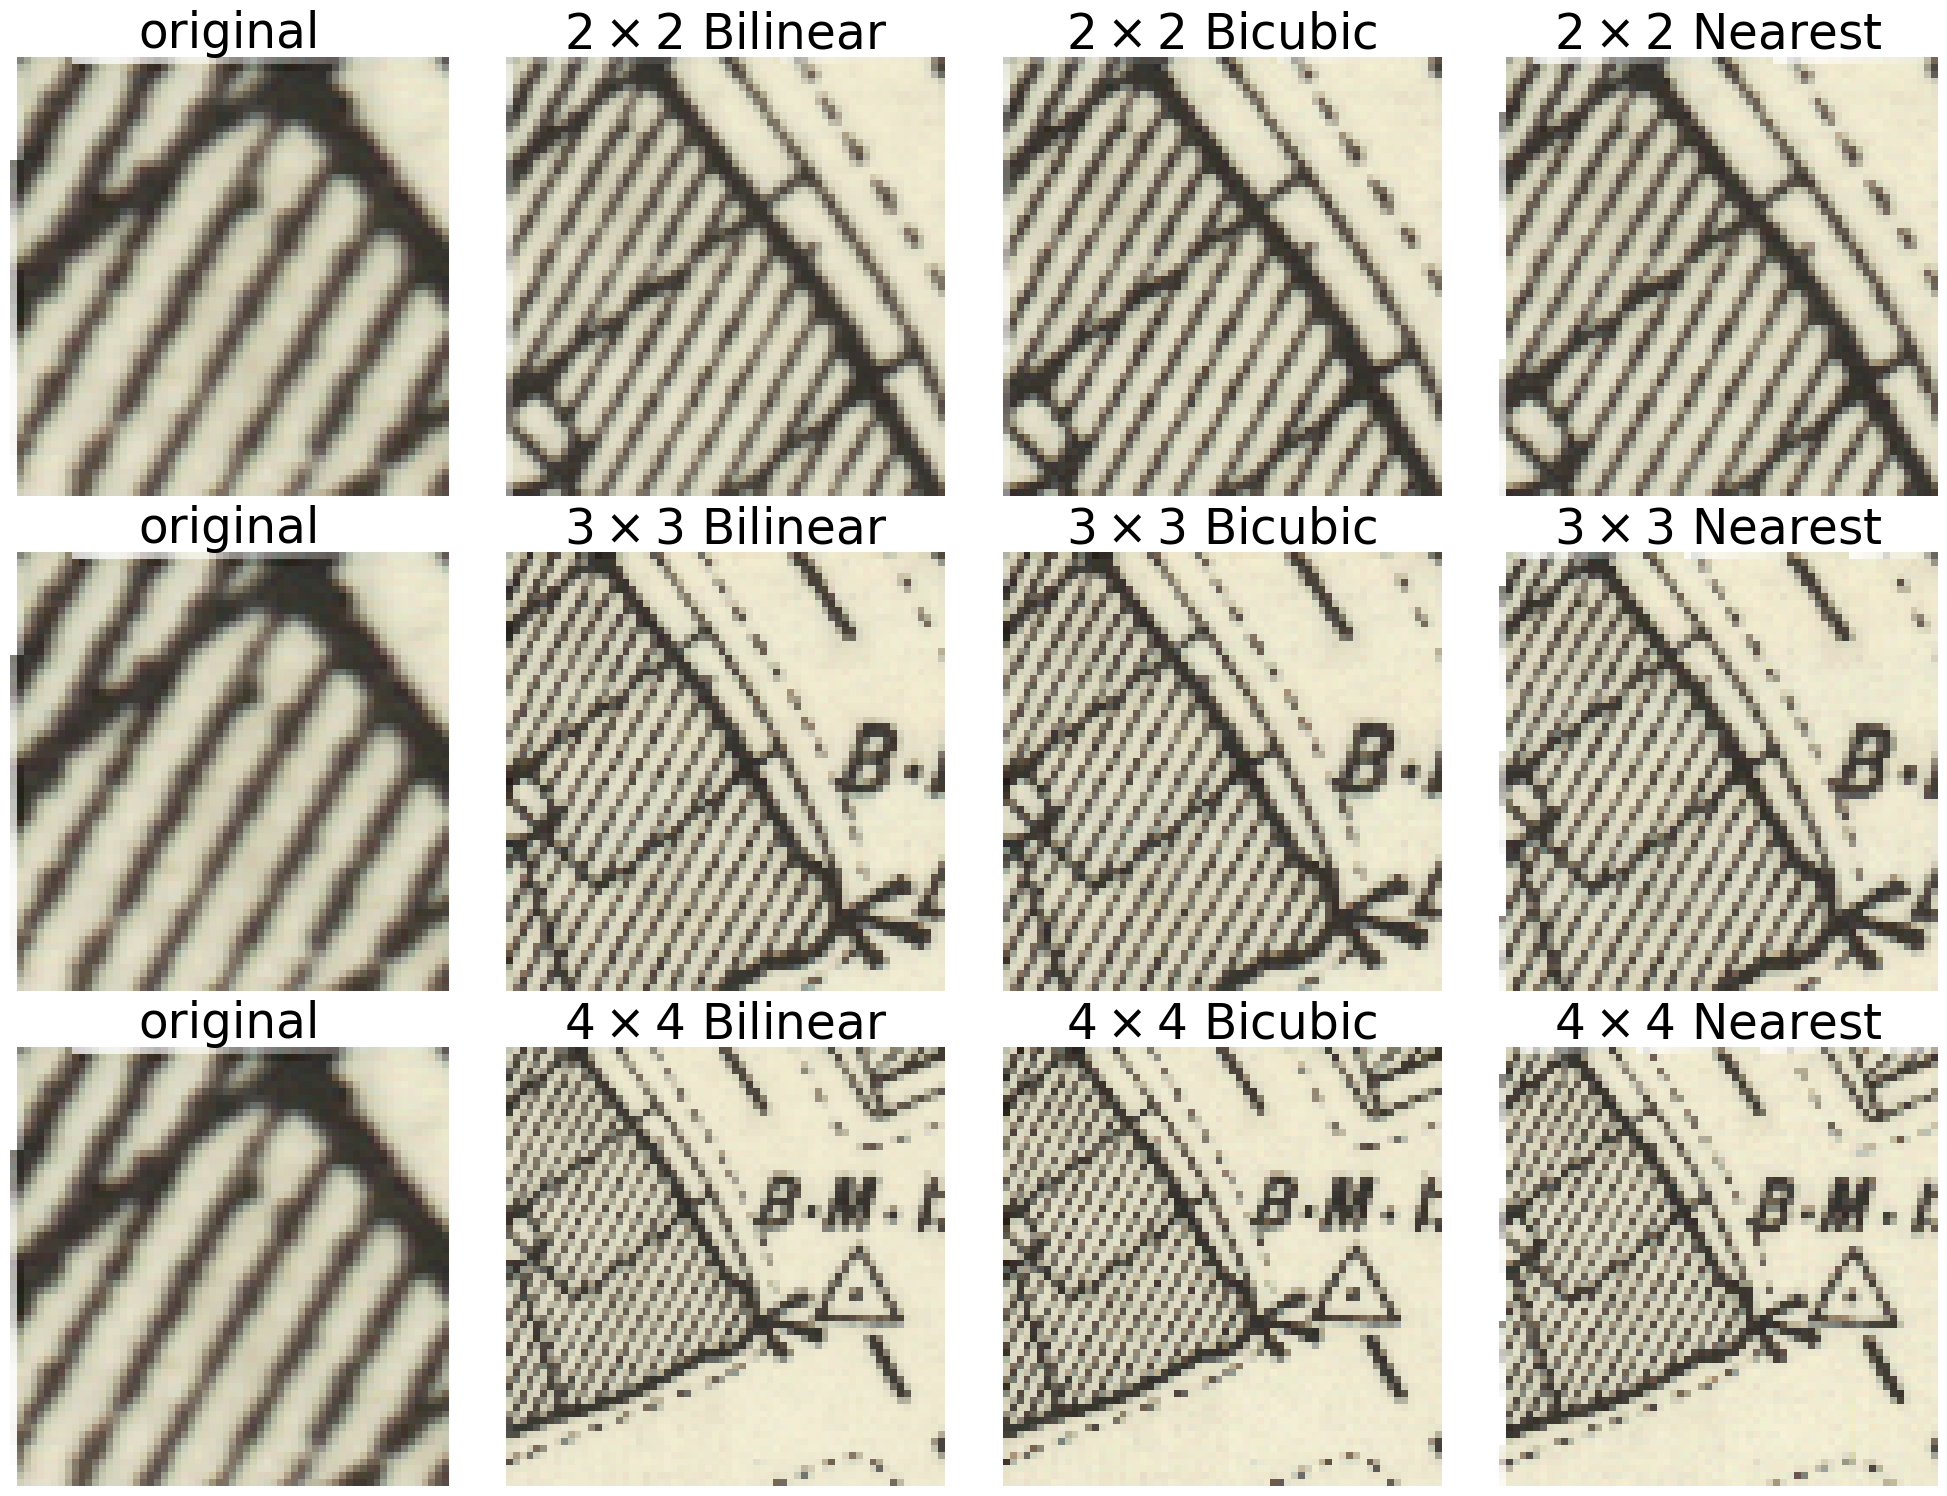

In [63]:
compare_map_transforms(map_dict, 64, (0,0), n_transforms=3, save = "../../pics/report/transcomparetorch.pdf")

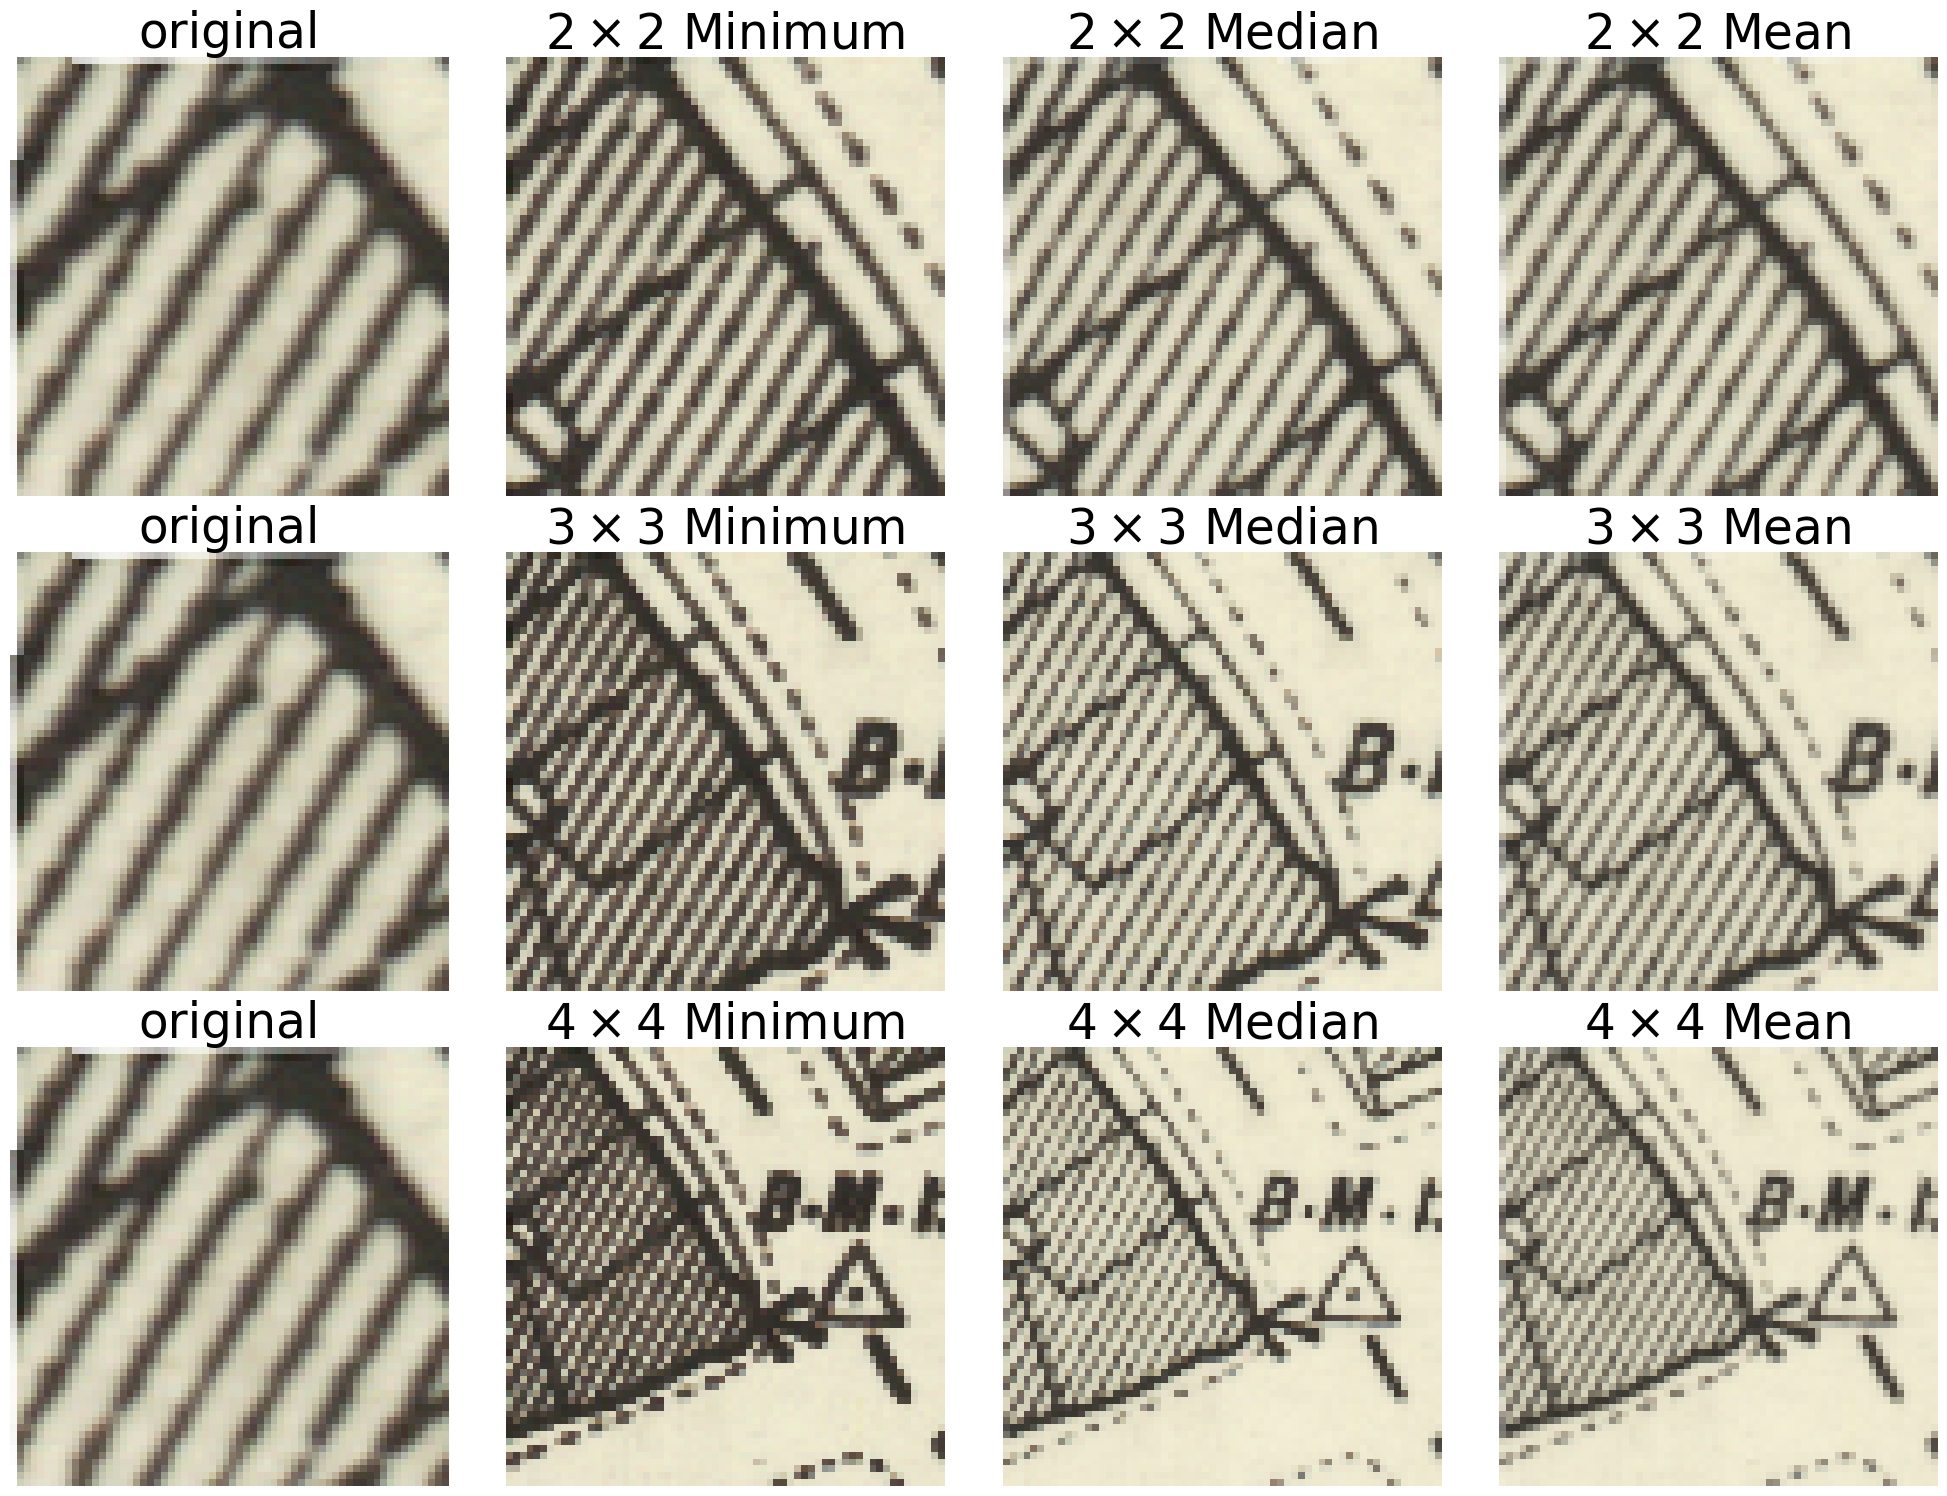

In [64]:
compare_map_transforms(map_dict_2, 64, (0,0), n_transforms=3, save = "../../pics/report/transcomparestat.pdf")

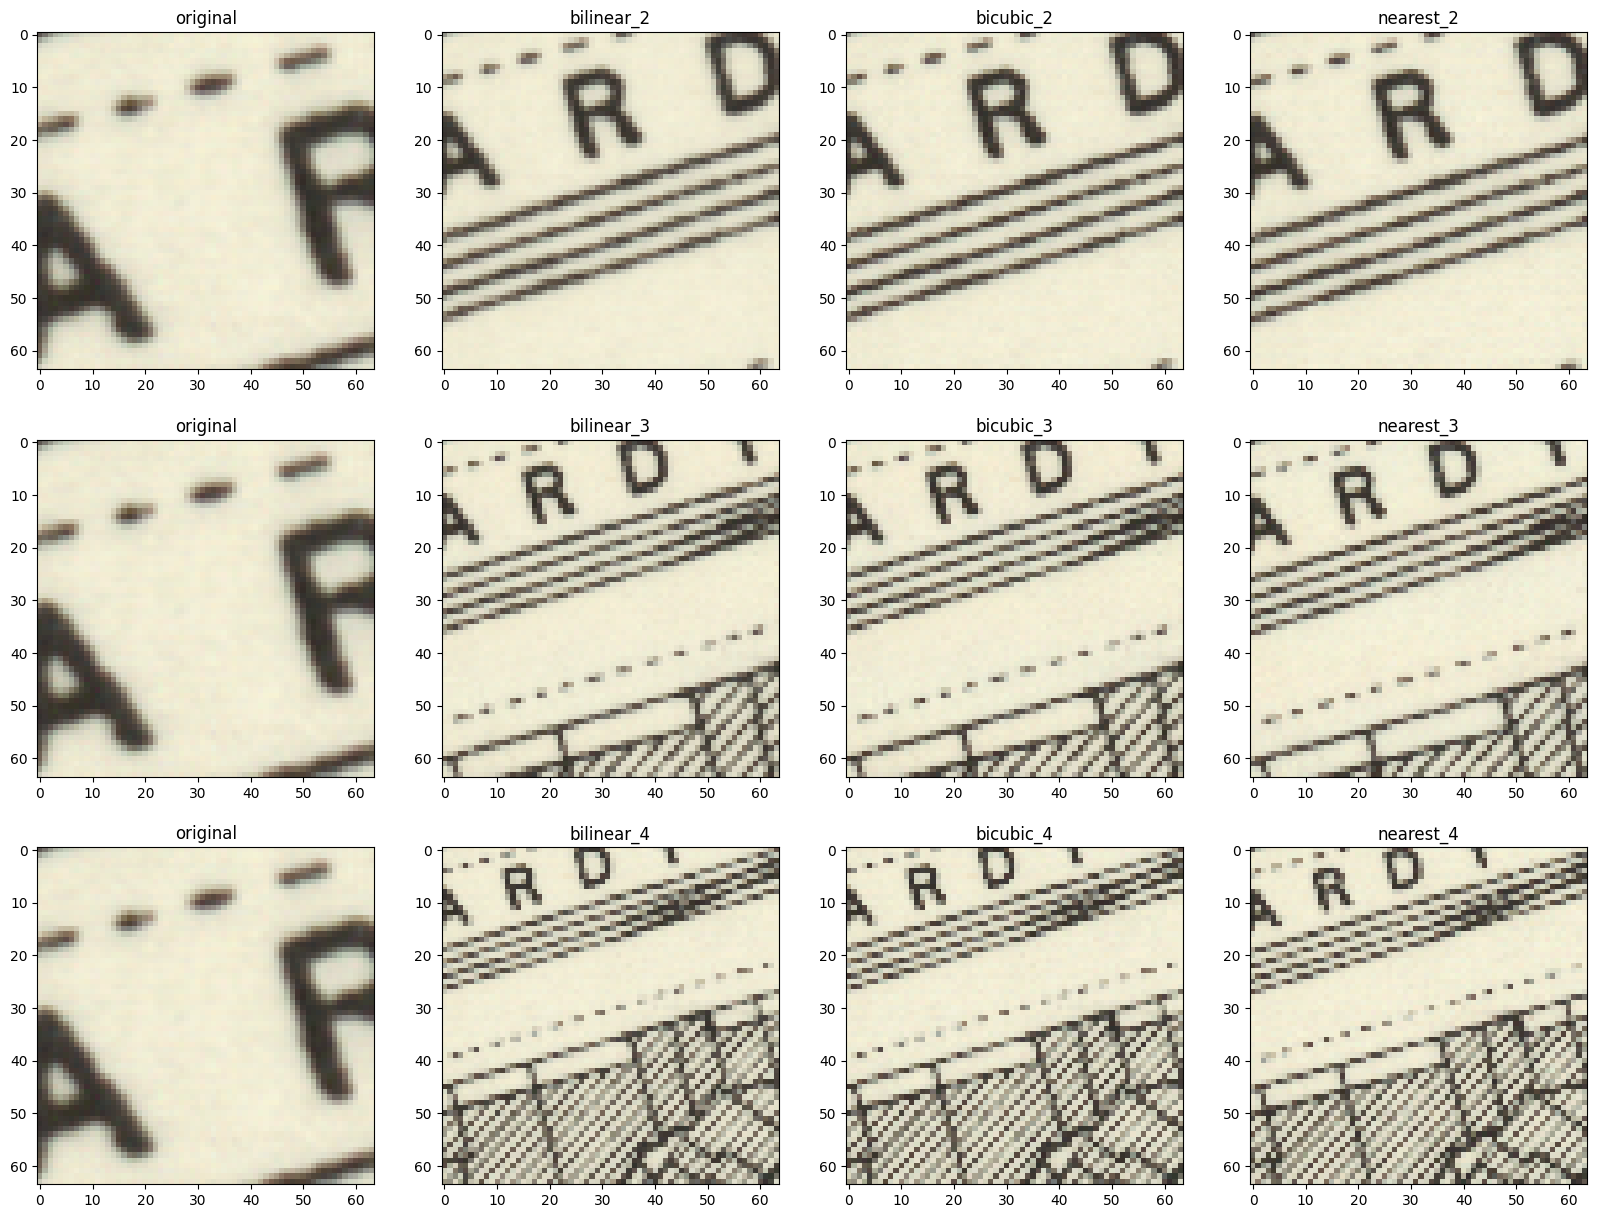

In [33]:
compare_map_transforms(map_dict, 64, (1200,1200), n_transforms=3, save = None)

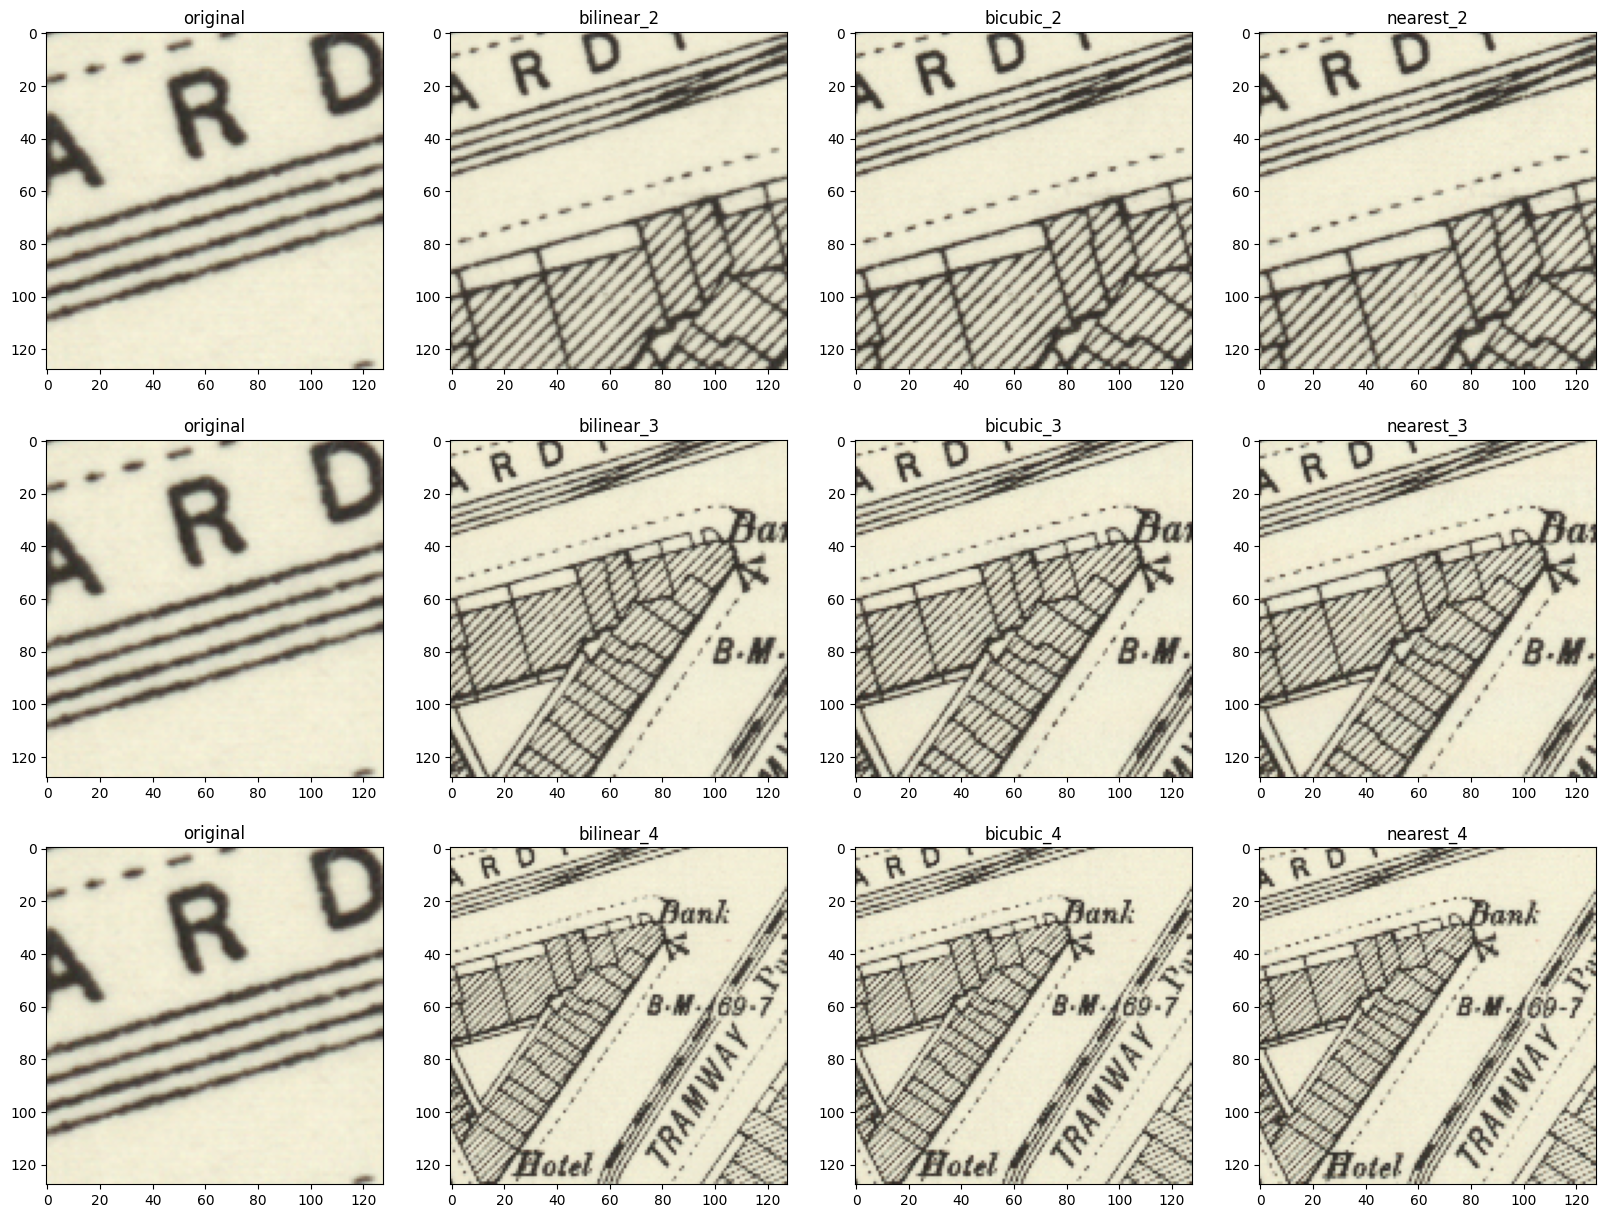

In [34]:
compare_map_transforms(map_dict, 128, (1200,1200), n_transforms=3, save = None)

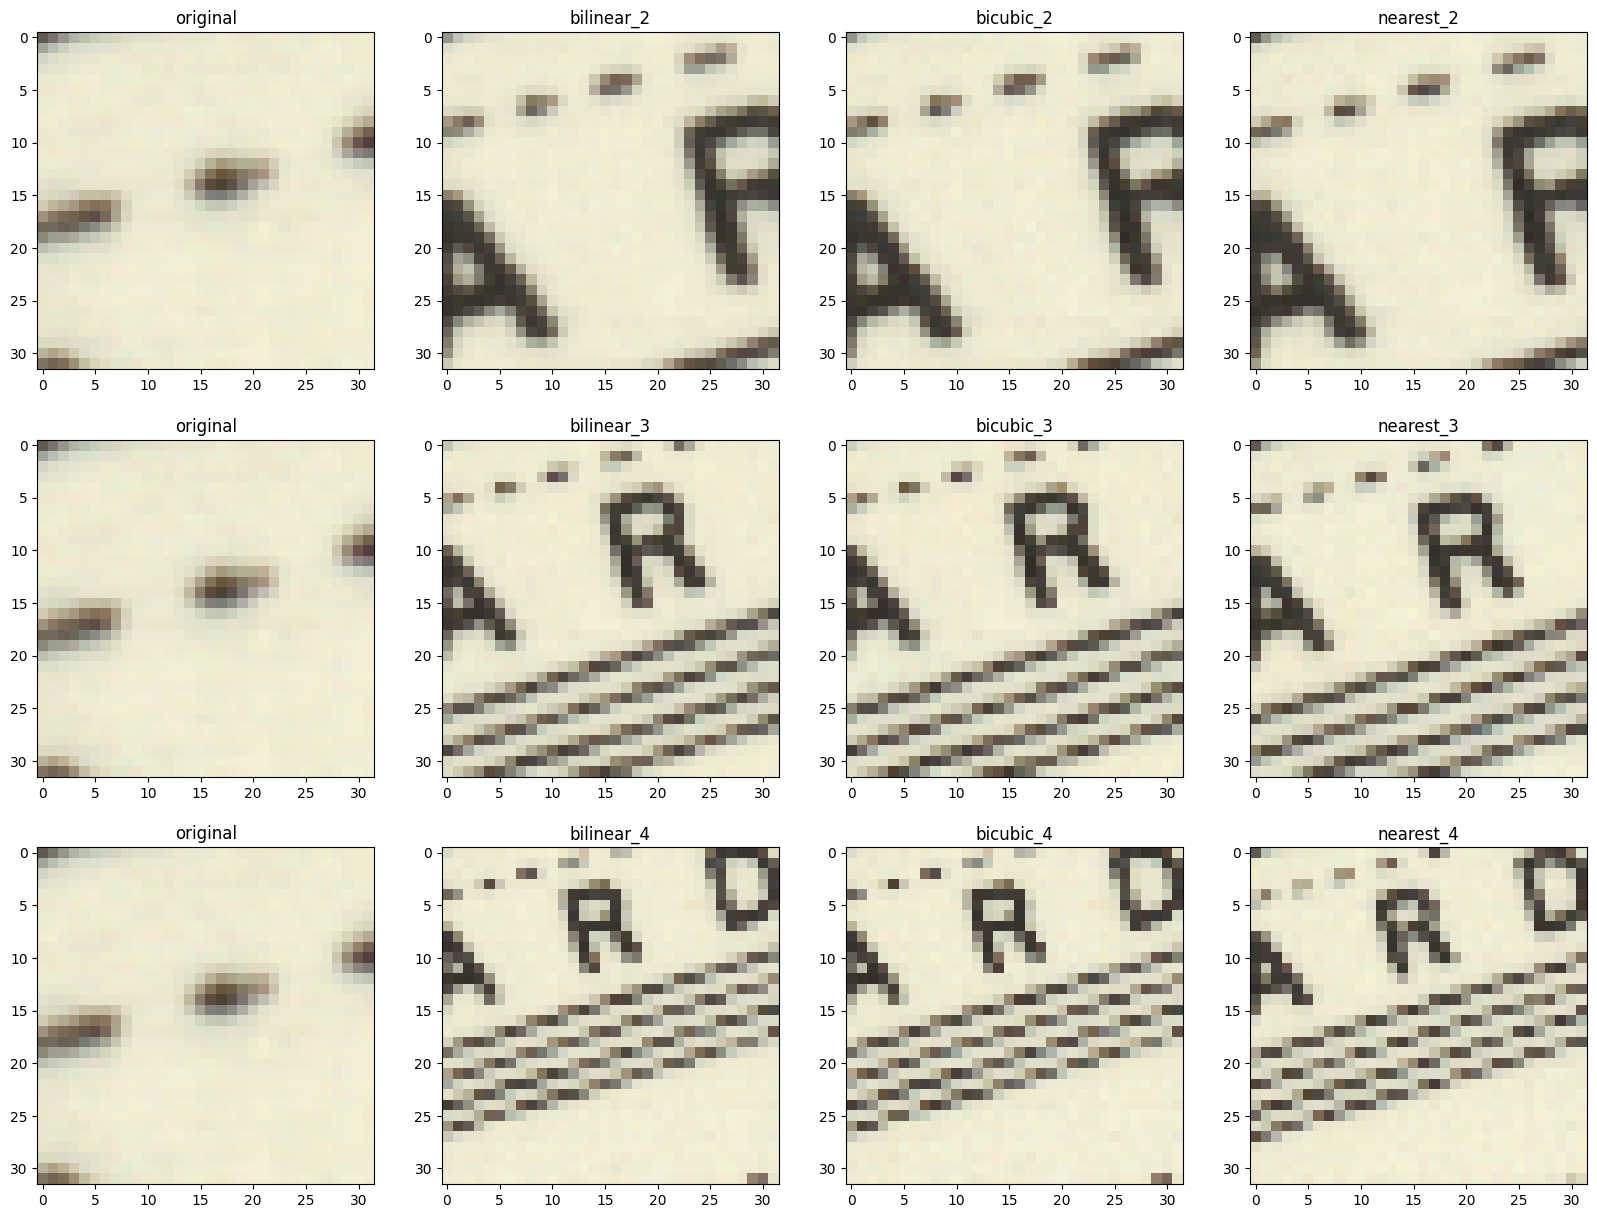

In [35]:
compare_map_transforms(map_dict, 32, (1200,1200), n_transforms=3, save = None)

Pytorch Resize uses bilinear interpolation by default: https://chao-ji.github.io/jekyll/update/2018/07/19/BilinearResize.html

For small kernels (2,3), NEAREST seems to work better (it seems to preserve contrast better). For kernel size 4 bicubic and bilinear seem to fare better. In general, PyTorch transforms seem to work better than the min/med pooling: